Philippe Joly 2025-08-05

# ALBATROS Signal with respect to the Ionosphere's Plasma Frequency

This notebook attempts to study the behaviour of ALBATROS's 4bit signal as the Ionosphere's plasma frequency, derived from A-CHAIM, evolves. 

In [62]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import sys
from scipy.interpolate import make_smoothing_spline
from os import path
sys.path.append(path.expanduser('~'))

outdir = "/scratch/s/sievers/philj0ly/Jupyter"

## Load CHAIM Data

In [2]:
fn = "/project/s/sievers/philj0ly/CHAIM/CSV/ACHAIM_nmf2.csv"

achaim = pd.read_csv(fn)

split_time = pd.to_datetime("240721_001020", format="%y%m%d_%H%M%S") # <-- to handle the big hole in the middle of the A-CHAIM data
   
achaim["datetime"] = pd.to_datetime(achaim["datetime"], format="%y%m%d_%H%M%S")
dfs = []
dfs.append(achaim[achaim["datetime"] <= split_time].copy())
dfs.append(achaim[achaim["datetime"] > split_time].copy())

print(f"Loaded {len(achaim)} Data points from A-CHAIM")

Loaded 1101 Data points from A-CHAIM


In [3]:
eps = 8.8541878188 * 1e-12 # vacuum electric permittivity  [ F / m]
m_e = 9.1093837139 * 1e-31 # electron mass [ kg ]
e = 1.602176634  * 1e-19 # electron charge [ C ]

def get_plasma_freq(nmf2):
    w_p = np.sqrt( nmf2 * e**2 / (m_e * eps) )
    return w_p / (2*np.pi)

for df in dfs:
    df["plasma_freq"] = get_plasma_freq(df["nmf2"])

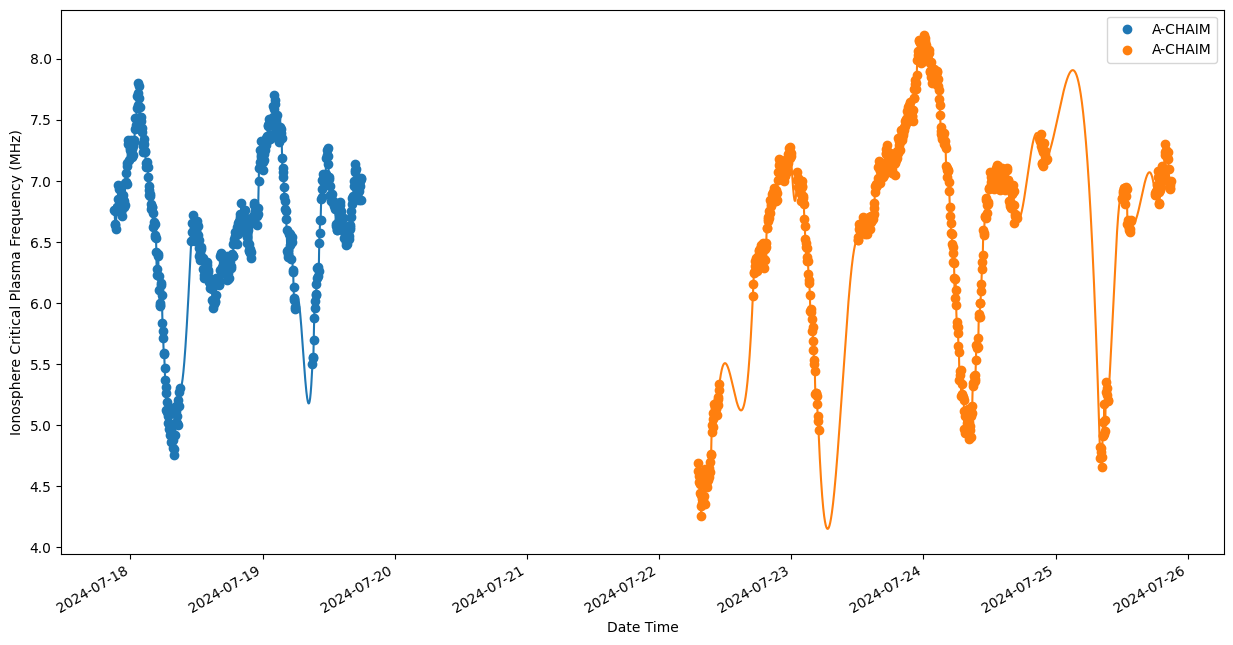

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
plasma = []

for df in dfs:
    ax.scatter(df["datetime"], df["plasma_freq"]*1e-6, label='A-CHAIM')

    # 70 000 is to give a ~5s dt over 4 days
    x = np.linspace(df["datetime"].values[0].astype(np.int64) // 10**9, df["datetime"].values[-1].astype(np.int64) // 10**9, 70000, endpoint=True)
    spl = make_smoothing_spline(df["datetime"].values.astype(np.int64) // 10**9, df["plasma_freq"].values, lam=0)

    plasma.append([pd.to_datetime(x, unit='s'), spl(x)])
    ax.plot(pd.to_datetime(x, unit='s'), spl(x)*1e-6)

plt.gcf().autofmt_xdate()

plt.xlabel("Date Time")
plt.ylabel("Ionosphere Critical Plasma Frequency (MHz)")
plt.legend()
plt.show()    

## Determination of Zones of Interest

Determination of which frequency bins to process at which times.

In [21]:
df_record = 125e6/2048 # (Hz) frequency range / # of channels
df = df_record/65536 # (Hz) / rechannelization factor

acclen = 458752
time_steps = 55

# freqs = chans*df # (Hz)
dt = acclen/df_record
times = dt*np.arange(time_steps)
print('time interval', dt, 's')

time interval 7.516192768 s


In [42]:
# Convert time to indxs (works for timestamps)
def get_closest(arr, n):
    diff = np.abs(arr-n)
    return np.argmin(diff)

t_pad = 60 # s +- around point
t_pad = pd.Timedelta(seconds=t_pad)
vis_list = []

t0 = []
for df in dfs:
    t0.append([df["datetime"].min(), df["datetime"].max()])
    vis_list.append([])

for i in range(len(t0)):
    t_curr = t0[i][0]
    t_end = t0[i][1]

    while t_curr <= t_end:
        j = get_closest(plasma[i][0], t_curr)
        vis_list[i].append([t_curr, plasma[i][1][j]])
        t_curr = t_curr+t_pad   

In [68]:
process_list = []
t_pad = 60 # s +- around point

for v in vis_list:
    for p in v:
        p[0] = int(p[0].timestamp())
        
    process_list.append([])
    current_state = v[0]
    final_t = v[0][0]
    
    for p in v:
        if p[1]//df_record == current_state[1]//df_record:
            final_t = p[0]
        else:
            process_list[-1].append([int(current_state[1]//df_record)-64, current_state[0]-t_pad, final_t+t_pad])
            current_state = p
            final_t = p[0]   
            
    process_list[-1].append([int(current_state[1]//df_record)-64, current_state[0]-t_pad, final_t+t_pad])


for i in range(len(process_list)):
    fn = f"processing_group{i}_times_{process_list[i][0][1]}_{process_list[i][-1][2]}.csv"
    process_list[i] = pd.DataFrame(np.array(process_list[i]), columns=["Frequency Bin (+64)", "Start Time", "End Time"])
    process_list[i].to_csv(path.join(outdir,fn), index=False)

This list will be used to process every necessary chunk of data. This has been done using the albatros_analysis library.

## Visualize ALBATROS Data

In [72]:
def visualize_heat(vis, plasma, freqs, times, spectrum, t_pad, f_pad, sz=(5,5), save_path=None):
    plt.figure(figsize=sz)
    extent = [
        vis[1]-f_pad,
        vis[1]+f_pad,
        vis[0]-t_pad, 
        vis[0]+t_pad
    ]

    # plt.imshow(
    #     np.log10(np.abs(spectrum[0, 0, 0].T)), aspect='auto', vmin=0, vmax=3, interpolation='none', origin="lower", extent=extent
    # )
    
    plt.imshow(
        np.log10(
            np.abs(
                spectrum[0, 0, 0, get_closest(times, vis[0]-t_pad):get_closest(times, vis[0]+t_pad)]
                    [get_closest(freqs, vis[1]-f_pad):get_closest(freqs, vis[1]+f_pad)].T)), 
        aspect='auto', vmin=0, vmax=3, interpolation='none', origin="lower", extent=extent
    )

    plt.scatter(df["plasma_freq"], df["datetime"].timestamp(), label='A-CHAIM Plasma Frequency')
    plt.plot(plasma[1], plasma[0].timestamp(), label='Interpolated Plasma Frequency')
    
    plt.ylabel("Unix Time (s)")
    plt.xlabel("Frequency (Hz)")
    plt.colorbar()

    if save_path is not None:
        plt.savefig(save_path)
    else:
       plt.show() 

def visualize_psd(vis, freqs, times, spectrum, f_pad, sz=(5,5)):
    plt.figures(figsize=sz)
    plt.plot(freqs, np.log10(np.abs(spectrum[0,0,0, get_closest(times, vis[0])])), label=pd.to_datetime(vis[0], unit='s'))
    plt.xlim(vis[1]-f_pad, vis[1]+f_pad)
    plt.axvline(vis[1], label="Plasma Frequency")

    plt.xlabel('Frequency (Hz)')   
    plt.ylabel('Log10 Amplitude')

    if save_path is not None:
        plt.savefig(save_path)
    else:
       plt.show() 

def visualize_band_evo(vis, times, spectrum, t_pad, sz=(5,5)):
    plt.figures(figsize=sz)
    plt.plot(times, np.log10(np.abs(spectrum[0,0,0][:, vis[1]])), label=f"{vis[1]} Hz")
    plt.xlim(vis[0]-t_pad, vis[0]+t_pad)
    plt.axvline(vis[0], label="Time of Plasma Frequency")

    plt.gcf().autofmt_xdate()
    plt.xlabel('Date Time')   
    plt.ylabel('Log10 Amplitude')
    
    if save_path is not None:
        plt.savefig(save_path)
    else:
       plt.show() 

In [73]:
pd.to_datetime(1721342139, unit='s')

Timestamp('2024-07-18 22:35:39')

In [74]:
pd.to_datetime(1721750623, unit='s')

Timestamp('2024-07-23 16:03:43')